In [9]:
'''Import data'''

import h5py 
import numpy as np
import pandas as pd

'''PLEASE REPLACE THE LOCATION OF THE FOLLOWING 3 INPUT FILES ACCORDINLY '''

with h5py.File(r"C:\Users\nqtru\Desktop\COMP5329\Assignment 1\Assignment-1-Dataset\train_128.h5",'r') as TU: 
    data = np.copy(TU['data'])
with h5py.File(r"C:\Users\nqtru\Desktop\COMP5329\Assignment 1\Assignment-1-Dataset\train_label.h5",'r') as TL:
    label = np.copy(TL['label'])
# Import predicted outputs for test data from Predicted_labels.h5
with h5py.File(r"C:\Users\nqtru\Desktop\COMP5329\Assignment 1\470518197_470490653_308012798\Code\Output\Predicted_labels.h5",'r') as TB:
    predicted_label = np.copy(TB['label'])
    
'''Standardise the data'''

mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

In [2]:
'''Define class for activation functions'''

class Activation(object):
    
    def relu (self,x):
        return np.maximum(x,0)  

    def relu_deriv (self,a):
        # a = np.maximum(x,0)
        a[a<0] = 0
        a[a>=0] = 1
        return a
    
    def leaky_relu (self,x):
        return np.maximum(x,0.1*x)  

    def leaky_relu_deriv (self,a):
        # a = np.maximum(x,0.1*x)
        a[a<0] = 0.1
        a[a>=0] = 1
        return a
    
    def softmax (self,x):
        # Normalise the input to prevent overflow problem in np.exp
        x_max = x.max()
        x_norm = x - x_max
        return np.exp(x_norm) / np.sum(np.exp(x_norm), axis=0)         
   
    def softmax_deriv (self, a):
        #a = np.exp(x) / np.sum(np.exp(x), axis=0)
        return a * (1 - a )
        
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )      
            
    def __init__(self,activation='relu'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'softmax':
            self.f = self.softmax
            self.f_deriv = self.softmax_deriv          
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv
        elif activation == 'relu':
            self.f = self.relu
            self.f_deriv = self.relu_deriv
        elif activation == 'leaky relu':
            self.f = self.leaky_relu
            self.f_deriv = self.leaky_relu_deriv
    

In [3]:
'''Define class for one hidden layer'''

class HiddenLayer(object): 
    
    # To keep the initialised weights and biases stable in across epochs
    import random
    random.seed(1)
    
    # Initialisation
    def __init__(self,n_in, n_out, W=None, b=None, activation=[0,1]):
        """   
        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: list of string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation[0]).f # Current layer's activation function
        self.activation_deriv=Activation(activation[1]).f_deriv # Previous layer's derivative activation function
        
        '''
        Initialize W
        Weight matrix W is of shape (n_in,n_out)
        '''     
        # Uniformly sampled with a variance of 2/n_in (He, et al, 2015)
        if activation[0] == 'relu':
            self.W = np.random.uniform(
                    low=-np.sqrt(2. / (n_in)), 
                    high=np.sqrt(2. / (n_in)),
                    size=(n_in, n_out)
            )
        # Uniformly sampled with a variance of 6/(n_in+n_out) (Glorot & Bengio, 2010)
        else: 
            self.W = np.random.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
            )
        # 4 times larger weights for logistic activation (Glorot & Bengio, 2010)
        if activation[0] == 'logistic':
            self.W *= 4
            
        '''
        Initialize b
        The bias vector b is of shape (n_out,)
        '''
        self.b = np.zeros(n_out,)
        
        ''' Intialise gradients of W,b of same shape as W,b'''
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        ''' Intialise velocities of W,b for Momentum & Adam updates, same shape as W,b'''
        self.velocity_W = np.zeros(self.W.shape)
        self.velocity_b = np.zeros(self.b.shape)
        
        ''' Intialise squared gradients for Adam update, same shape as W,b '''
        self.sqr_grad_W = np.zeros(self.W.shape) 
        self.sqr_grad_b = np.zeros(self.b.shape) 
        
        
    '''Forward Propagation'''
    def forward(self, input):
        '''
        :type input: numpy.array
        :input: input data/activations from previous layers
        '''
        #hidden_layer_input= matrix_dot_product(X,wh) + bh
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    '''Backward Propagation'''
    def backward(self, delta, learning_rate):
        # Calculate gradients of W,b
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        # return delta_ for next layer
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta_
    
    '''Update parameters with momentum'''
    def momentum_update(self, learning_rate=0.001, beta=0.9):
        # Update velocities of W,b
        self.velocity_W = beta*self.velocity_W + (1-beta)*self.grad_W
        self.velocity_b = beta*self.velocity_b + (1-beta)*self.grad_b
        # Update W,b
        self.W -= learning_rate * self.velocity_W
        self.b -= learning_rate * self.velocity_b 
    
    '''Update parameters with Adam'''
    ### Reference: Andrew Ng's Deep Learning on Coursera
    ### https://www.coursera.org/specializations/deep-learning
    def adam_update(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        '''
        :beta1, beta2: values of beta (float) for Adam update
        :epsilon: a very small float
        '''
        # Update velocity of W,b
        self.velocity_W = beta1*self.velocity_W + (1-beta1)*self.grad_W
        self.velocity_b = beta1*self.velocity_b + (1-beta1)*self.grad_b
        # Correct the velocity of W,b
        velocity_corrected_W = self.velocity_W / (1-beta1**2+epsilon)  # added epsilon to prevent 0 denominator
        velocity_corrected_b = self.velocity_b / (1-beta1**2+epsilon)  # added epsilon to prevent 0 denominator
        # Calculate squared gradients of W,b
        self.sqr_grad_W = beta2 * self.sqr_grad_W + (1-beta2) * np.power(self.grad_W,2)
        self.sqr_grad_b = beta2 * self.sqr_grad_b + (1-beta2) * np.power(self.grad_b,2)
        # Correct the squared gradients of W,b
        sqr_grad_corrected_W = self.sqr_grad_W / (1-beta2**2+epsilon) # added epsilon to prevent 0 denominator
        sqr_grad_corrected_b = self.sqr_grad_b / (1-beta2**2+epsilon) # added epsilon to prevent 0 denominator   
        # Update W,b
        self.W -= learning_rate * (velocity_corrected_W/(np.sqrt(sqr_grad_corrected_W)+epsilon)) # added epsilon to prevent 0 denominator
        self.b -= learning_rate * (velocity_corrected_b/(np.sqrt(sqr_grad_corrected_b)+epsilon)) # added epsilon to prevent 0 denominator
        
        

In [4]:
'''Define class for the neural network'''

class MLP:
    
    # Initialisation
    def __init__(self, layers, activations):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activations: The list of activation functions to be used. Can be
        "logistic", "tanh", "relu" , "leaky relu" or "softmax
        """        
        ### initialize layers
        self.layers=[]  
        self.activations = activations # activation functions of each layer, index corresponds layer number
        self.output_count = layers[-1] # number of output in the output layer
        self.params=[]
        self.dropout_fraction = 1 # 1 means no dropout, otherwise would be between 0 and 1
        
        # Create hidden layers
        for i in range(len(layers)-1):
            # Create a new layer with params: number of inputs, outputs, activation of itself and of previous layer
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation=[activations[i],activations[i-1]]))   
    
    '''Forward propagation'''
    def forward(self,input,predict):
        """
        :type input: numpy.array
        :input: input data/activations from previous layers
        :type input: boolean
        :predict: True means forward step in prediction, 
                  False means forward step in training 
        """
        for i in range(len(self.layers)):
            output = self.layers[i].forward(input)
            # Apply dropout between hidden layers only
            if i > 0 and i < len(self.layers)-1 and not predict: # Dropout in training steps
                output = self.dropout(output)
            elif predict: # Dropout in predict step 
                output = output * self.dropout_fraction     
            input=output
        return output
    
    '''Dropout module'''
    ### Reference: Andrew Ng's Deep Learning on Coursera
    ### https://www.coursera.org/specializations/deep-learning
    def dropout(self,input):
        # Create a random dropout array with given dropout percentage
        dropout_array = np.random.binomial(1, self.dropout_fraction, size=input.shape[0])
        input = input * dropout_array
        return input
    
    '''Mean Squared Error'''
    def criterion_MSE(self,y,y_hat):
        # Convert y_hat into an array of size 10 consisting of 0,1 (probability of each class)
        y_true = np.zeros(y_hat.shape)
        y_true[y] = 1
        activation_deriv=Activation(self.activations[-1]).f_deriv
        # MSE
        error = y_true-y_hat
        loss=error**2
        # write down the delta in the last layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
    
    '''Cross Entropy'''
    def cross_entropy_loss(self,y,y_hat):
        # Convert y_hat into an array of size 10 consisting of 0,1 (probability of each class)
        y_true = np.zeros(y_hat.shape)
        y_true[y] = 1
        # Cross entropy loss
        loss = -np.log(y_hat[y]+1e-15) # adding 1e-15 to prevent log(0)
        # write down the delta in the last layer
        delta = y_hat-y_true 
        return loss,delta
    
    '''Backward propagation'''
    def backward(self,delta,learning_rate=0.001):
        for layer in reversed(self.layers):
            delta = layer.backward(delta,learning_rate)
            
    '''Gradient Descent parameters W,b updates'''
    def update(self,learning_rate=0.001,beta1=0.9,beta2=0.999,optimizer=None):
        """
        :learning_rate: learning rate (float)
        :beta1, beta2: beta values (float) for Momentum & Adam updates
        :optimizer: Gradient Descent optimizer, can be "momentum", "adam" or None
        """
        for layer in self.layers:
            # Momentum
            if optimizer == 'momentum':
                layer.momentum_update(learning_rate,beta1)
            # Adam
            elif optimizer == 'adam':
                layer.adam_update(learning_rate,beta1,beta2,1e-8)
            # Stochastic only
            elif optimizer == None:
                layer.W -= learning_rate * layer.grad_W
                layer.b -= learning_rate * layer.grad_b

    '''Fit training data'''
    def fit(self,X_train,y_train,X_test,y_test,learning_rate=0.001, beta1=0.9, beta2=0.999, epochs=100, optimizer=None, dropout=1):
        """
        Online learning.
        :param X_train: Train data or features
        :param y_train: Train targets
        :param X_test: Test data or features
        :param y_test: Test targets
        :param learning_rate: parameters defining the speed of learning
        :param beta1, beta2: Beta values for Momentum / Adam updates
        :param epochs: number of times the dataset is presented to the network for learning
        :optimizer: Gradient Descent optimizer, can be "momentum", "adam" or None
        :dropout: Dropout fraction between 0 to 1, 1 means no dropout
        """ 
        # Store dropout fraction
        self.dropout_fraction = dropout
        # To store test accuracy of each epoch
        accuracies = []
        # To store max test accuracy, min loss and their epoch
        max_accuracy = 0
        max_epoch = -1
        min_loss = 1e20
        min_epoch = -1
        # Convert inputs into arrays
        X=np.array(X_train)
        y=np.array(y_train)
        # Array to store the loss of each epoch
        to_return = np.zeros(epochs)

        '''Train data for each epoch'''
        for k in range(epochs):
            # Initialise loss for each training sample
            loss=np.zeros(X.shape[0])
            # For each training sample
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                # forward pass
                y_hat = self.forward(X[i],False)
                # backward pass
                loss[it],delta=self.cross_entropy_loss(y[i],y_hat)
                self.backward(delta,learning_rate)
                # update parameters
                self.update(learning_rate,beta1,beta2,optimizer)
            # Calculate the mean loss over all training samples
            to_return[k] = np.mean(loss) 
            
            '''Calculate and print accuracy, loss in each epoch'''
            # Predict on test data
            y_pred_test = self.predict(X_test)
            y_pred_test = np.argmax(y_pred_test,axis=1)
            # Predict on train data
            y_pred_train = self.predict(X_train)
            y_pred_train = np.argmax(y_pred_train,axis=1)
            # Print test/train accuracies and loss
            print('Epoch: {}\t| Test Accuracy: {:0.2f}% | Train Accuracy: {:0.2f}% | Loss: {:0.4f}'.format(k+1,getAccuracy(y_test, y_pred_test)*100,getAccuracy(y_train, y_pred_train)*100,to_return[k]))
            # Keep test accuracy 
            accuracies.append(getAccuracy(y_test, y_pred_test)*100)
            # Obtain max accuracy and min loss values
            if getAccuracy(y_test, y_pred_test)*100 > max_accuracy:
                max_accuracy = getAccuracy(y_test, y_pred_test)*100
                max_epoch = k+1
            if to_return[k] < min_loss:
                min_loss = to_return[k]
                min_epoch = k+1
            
        # Calculate and print mean accuracy, loss over all epochs
        print('Mean Accuracy: {:0.2f}%'.format(np.mean(accuracies)))
        print('Maximum Accuracy: {:0.2f}% reached at epoch {}'.format(max_accuracy,max_epoch))
        print('Mean Loss: {:0.4f}'.format(np.mean(to_return)))
        print('Minimum Loss: {:0.4f} reached at epoch {}'.format(min_loss,min_epoch))
        
        # Return loss values of all epochs
        return to_return
    

    '''Predict output for test data'''
    def predict(self, x):
        x = np.array(x)
        output = np.zeros((x.shape[0],self.output_count))
        for i in np.arange(x.shape[0]):
            output[i] = nn.forward(x[i,:],True)
        return output
    
        

In [5]:
'''Calculate accuracy between predict and true outputs'''
def getAccuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return (correct/float(len(y_true)))

Epoch: 1	| Test Accuracy: 84.83% | Train Accuracy: 85.06% | Loss: 0.5350
Epoch: 2	| Test Accuracy: 85.80% | Train Accuracy: 86.53% | Loss: 0.3970
Epoch: 3	| Test Accuracy: 86.53% | Train Accuracy: 87.31% | Loss: 0.3616
Epoch: 4	| Test Accuracy: 87.33% | Train Accuracy: 88.24% | Loss: 0.3446
Epoch: 5	| Test Accuracy: 87.42% | Train Accuracy: 88.64% | Loss: 0.3254
Epoch: 6	| Test Accuracy: 87.48% | Train Accuracy: 88.81% | Loss: 0.3060
Epoch: 7	| Test Accuracy: 87.10% | Train Accuracy: 88.83% | Loss: 0.2998
Epoch: 8	| Test Accuracy: 87.97% | Train Accuracy: 89.67% | Loss: 0.2886
Epoch: 9	| Test Accuracy: 88.02% | Train Accuracy: 89.86% | Loss: 0.2825
Epoch: 10	| Test Accuracy: 88.07% | Train Accuracy: 90.19% | Loss: 0.2751
Epoch: 11	| Test Accuracy: 88.10% | Train Accuracy: 90.17% | Loss: 0.2662
Epoch: 12	| Test Accuracy: 88.28% | Train Accuracy: 90.76% | Loss: 0.2574
Epoch: 13	| Test Accuracy: 88.12% | Train Accuracy: 90.71% | Loss: 0.2521
Epoch: 14	| Test Accuracy: 88.52% | Train Accur

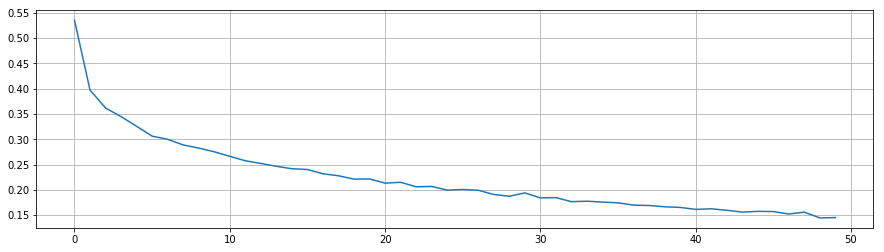

In [97]:
%%time

'''Define training and test data of ratio 9:1'''
# Test
x_train = data[0:54000,:]
y_train = label[0:54000]
# Train
x_test = data[54000:60000,:]
y_test = label[54000:60000]

'''Initialise the proposed neural network'''
nn = MLP([128,100,100,10],['tanh','relu','softmax'])

'''Fit data to train the model'''
loss = nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.001, beta1=0.9, beta2=0.999, epochs=50, optimizer='momentum', dropout=1) 

'''Plot loss'''
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
pl.figure(figsize=(15,4))
pl.plot(loss)
pl.grid()

In [7]:
'''Check predicted outputs for test data from Predicted_labels.h5'''

# Print its type, shape, first 100 predicted labels
print(type(predicted_label))
print(predicted_label.shape)
print(predicted_label[0:100])

<class 'numpy.ndarray'>
(10000,)
[9 2 1 1 0 1 4 6 5 7 4 5 5 3 4 1 2 2 8 0 2 5 7 5 1 4 4 0 9 4 8 8 3 3 8 0 7
 5 7 9 0 1 6 5 4 9 2 1 2 6 4 4 5 0 2 2 8 4 8 0 7 7 8 5 1 1 0 4 7 8 7 0 6 6
 2 1 1 2 8 4 1 8 5 9 5 0 1 2 0 0 5 1 6 7 1 8 0 1 4 2]
